Assignment 10 Supplementary: Semantic Search Demo
===============

This Python notebook guides you through the code for Text-to-Image and Image-to-Image search.

Prior to starting, you should have a file called `image_embeddings.pickle` and a file called `coco_images_resized.zip` in the current directory.

First, unzip `coco_images_resized.zip`. This directory contains the images that you will search through.

This assignment uses pretrained CLIP (Contrastive Language Image Pretrained) models to embed text and images into a joint embedding space. You can read about CLIP models here: https://www.pinecone.io/learn/clip-image-search/

**Your end goal is to find the most relevant images given either an image or a text query.**

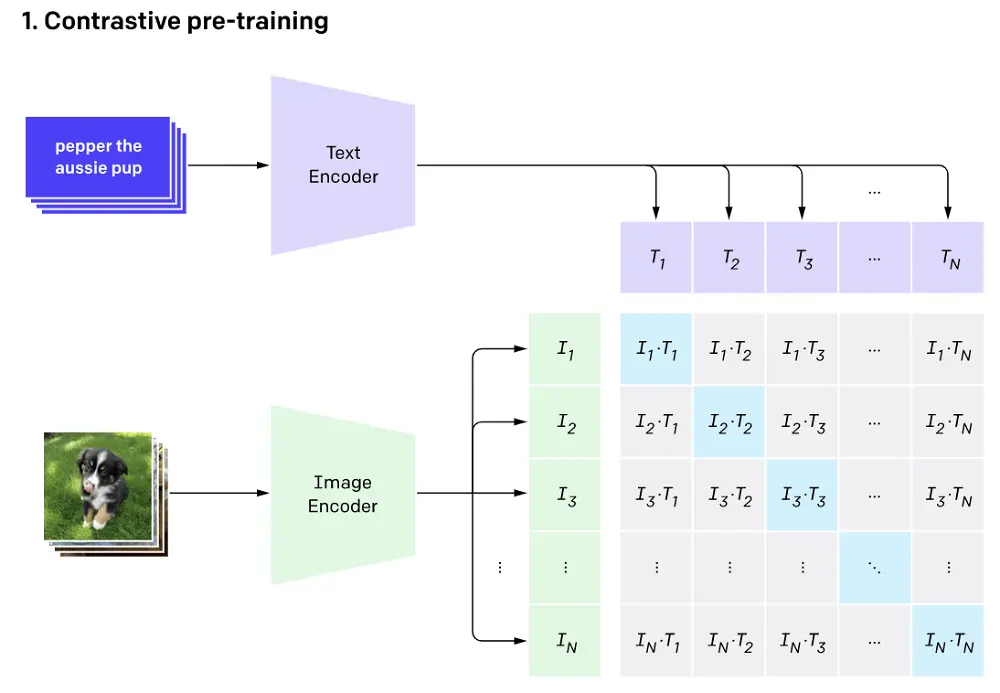

### Step 1: Caclulate Image Embeddings for Dataset

We first want to make our image database easily searchable. To achieve this, we calculate the image embedding for each image using the image encoder. **This has already been done for you,** because it is computationally intensive. Below is the code for reference.

In [ ]:
# import os
# import torch
# import torchvision.transforms as transforms
# from PIL import Image
# from open_clip import create_model_and_transforms, tokenizer
# import torch.nn.functional as F
# import pandas as pd
# from tqdm import tqdm

# # Configuration
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model_name = "ViT-B/32"
# pretrained = "openai"
# batch_size = 128
# image_folder = "/scratch/cliao25/train2014/train2014"  # Replace with your folder path

# # Load the model and preprocess function
# model, preprocess_train, preprocess_val = create_model_and_transforms(model_name, pretrained=pretrained)
# model = model.to(device)
# model.eval()

# # Image transformations (using preprocess_val from open_clip)
# transform = preprocess_val

# # Collect all image paths
# image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
# print('Number of images:', len(image_paths))
# # DataFrame to store results
# results = []

# # Function to load and preprocess images
# def load_images(batch_paths):
#     images = []
#     for path in batch_paths:
#         try:
#             image = Image.open(path).convert("RGB")
#             images.append(transform(image))
#         except Exception as e:
#             print(f"Error loading image {path}: {e}")
#     return torch.stack(images) if images else None

# # Process images in batches
# with torch.no_grad():
#     for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing images"):
#         batch_paths = image_paths[i:i + batch_size]
#         images = load_images(batch_paths)
#         if images is None:  # Skip if no valid images in this batch
#             continue

#         images = images.to(device)
#         embeddings = model.encode_image(images)
#         embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize the embeddings

#         for path, emb in zip(batch_paths, embeddings):
#             results.append({"file_name": os.path.basename(path), "embedding": emb.cpu().numpy()})

# Save results to a DataFrame
# df = pd.DataFrame(results)
# df.to_pickle('image_embeddings.pickle')

Number of images: 82783


Processing images: 100%|██████████████████████| 647/647 [06:46<00:00,  1.59it/s]


Run the code below to examine the dataframe.

The dataframe `df` has two columns. The first column is the image file in the dataset folder. The second column is the image embedding corresponding to that image.

In [10]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import os

In [1]:
import pandas as pd
df = pd.read_pickle('image_embeddings.pickle')
df

file_name  \
0      COCO_train2014_000000017154.jpg   
1      COCO_train2014_000000356738.jpg   
2      COCO_train2014_000000124428.jpg   
3      COCO_train2014_000000277426.jpg   
4      COCO_train2014_000000474616.jpg   
...                                ...   
82778  COCO_train2014_000000090708.jpg   
82779  COCO_train2014_000000493505.jpg   
82780  COCO_train2014_000000517584.jpg   
82781  COCO_train2014_000000234720.jpg   
82782  COCO_train2014_000000541893.jpg   

                                               embedding  
0      [-0.013383481, 0.025817081, 0.027312446, 0.029...  
1      [-0.018858824, 0.066932686, -0.023063071, -0.0...  
2      [0.034829315, -0.014156876, -0.0095499605, 0.0...  
3      [-0.00678755, -0.04286685, 0.0022111333, -0.02...  
4      [0.017978659, 0.002254282, -0.00318466, 0.0169...  
...                                                  ...  
82778  [-0.03795312, -0.012270769, 0.009529039, 0.018...  
82779  [-0.013693268, 0.03612202, -0.018199965, 0.000...  
82780  [0.018850781, -0.0006246638, -0.02557726, 0.03...  
82781  [-0.008946741, -0.00071093737, -0.009944752, 0...  
82782  [0.0123360595, 0.04418458, 0.0014363881, 0.005...  

[82783 rows x 2 columns]

### Step 2: Image-to-Image Search

Now you will write some code to find the closest image in the dataset to a given image query.

Find a random image off the internet. Use the CLIP image encoder to encode the image; let's call this the `query_embedding`.

Now, display the image in the dataset that has the **maximum cosine similarity with the query embedding.**

**It is very important that you use the `ViT-B/32, openai` version of the CLIP model** to be consistent with the embeddings you were given.

Here's the documentation for CLIP: https://github.com/mlfoundations/open_clip

**Hint:** Take advantage of the code given to you at the bedginning of this assignment.

In [2]:
! pip install open-clip-torch

  Using cached torch-2.2.2-cp38-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached huggingface_hub-0.26.5-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.4.5-cp38-cp38-macosx_10_12_x86_64.whl.metadata (3.8 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 397.4 kB/s eta 0:00:00a 0:00:01
Using cached torch-2.2.2-cp38-none-macosx_10_9_x86_64.whl (150.6 MB)
Using cached huggingface_hub-0.26.5-py3-none-any.whl (447 kB)
Using cached safetensors-0.4.5-cp38-cp38-macosx_10_12_x86_64.whl (392 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 888.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.1 MB/s eta 0:00:00a 0:00:01
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 1.1 MB/s eta 0:00:00a 0:

This is my query image


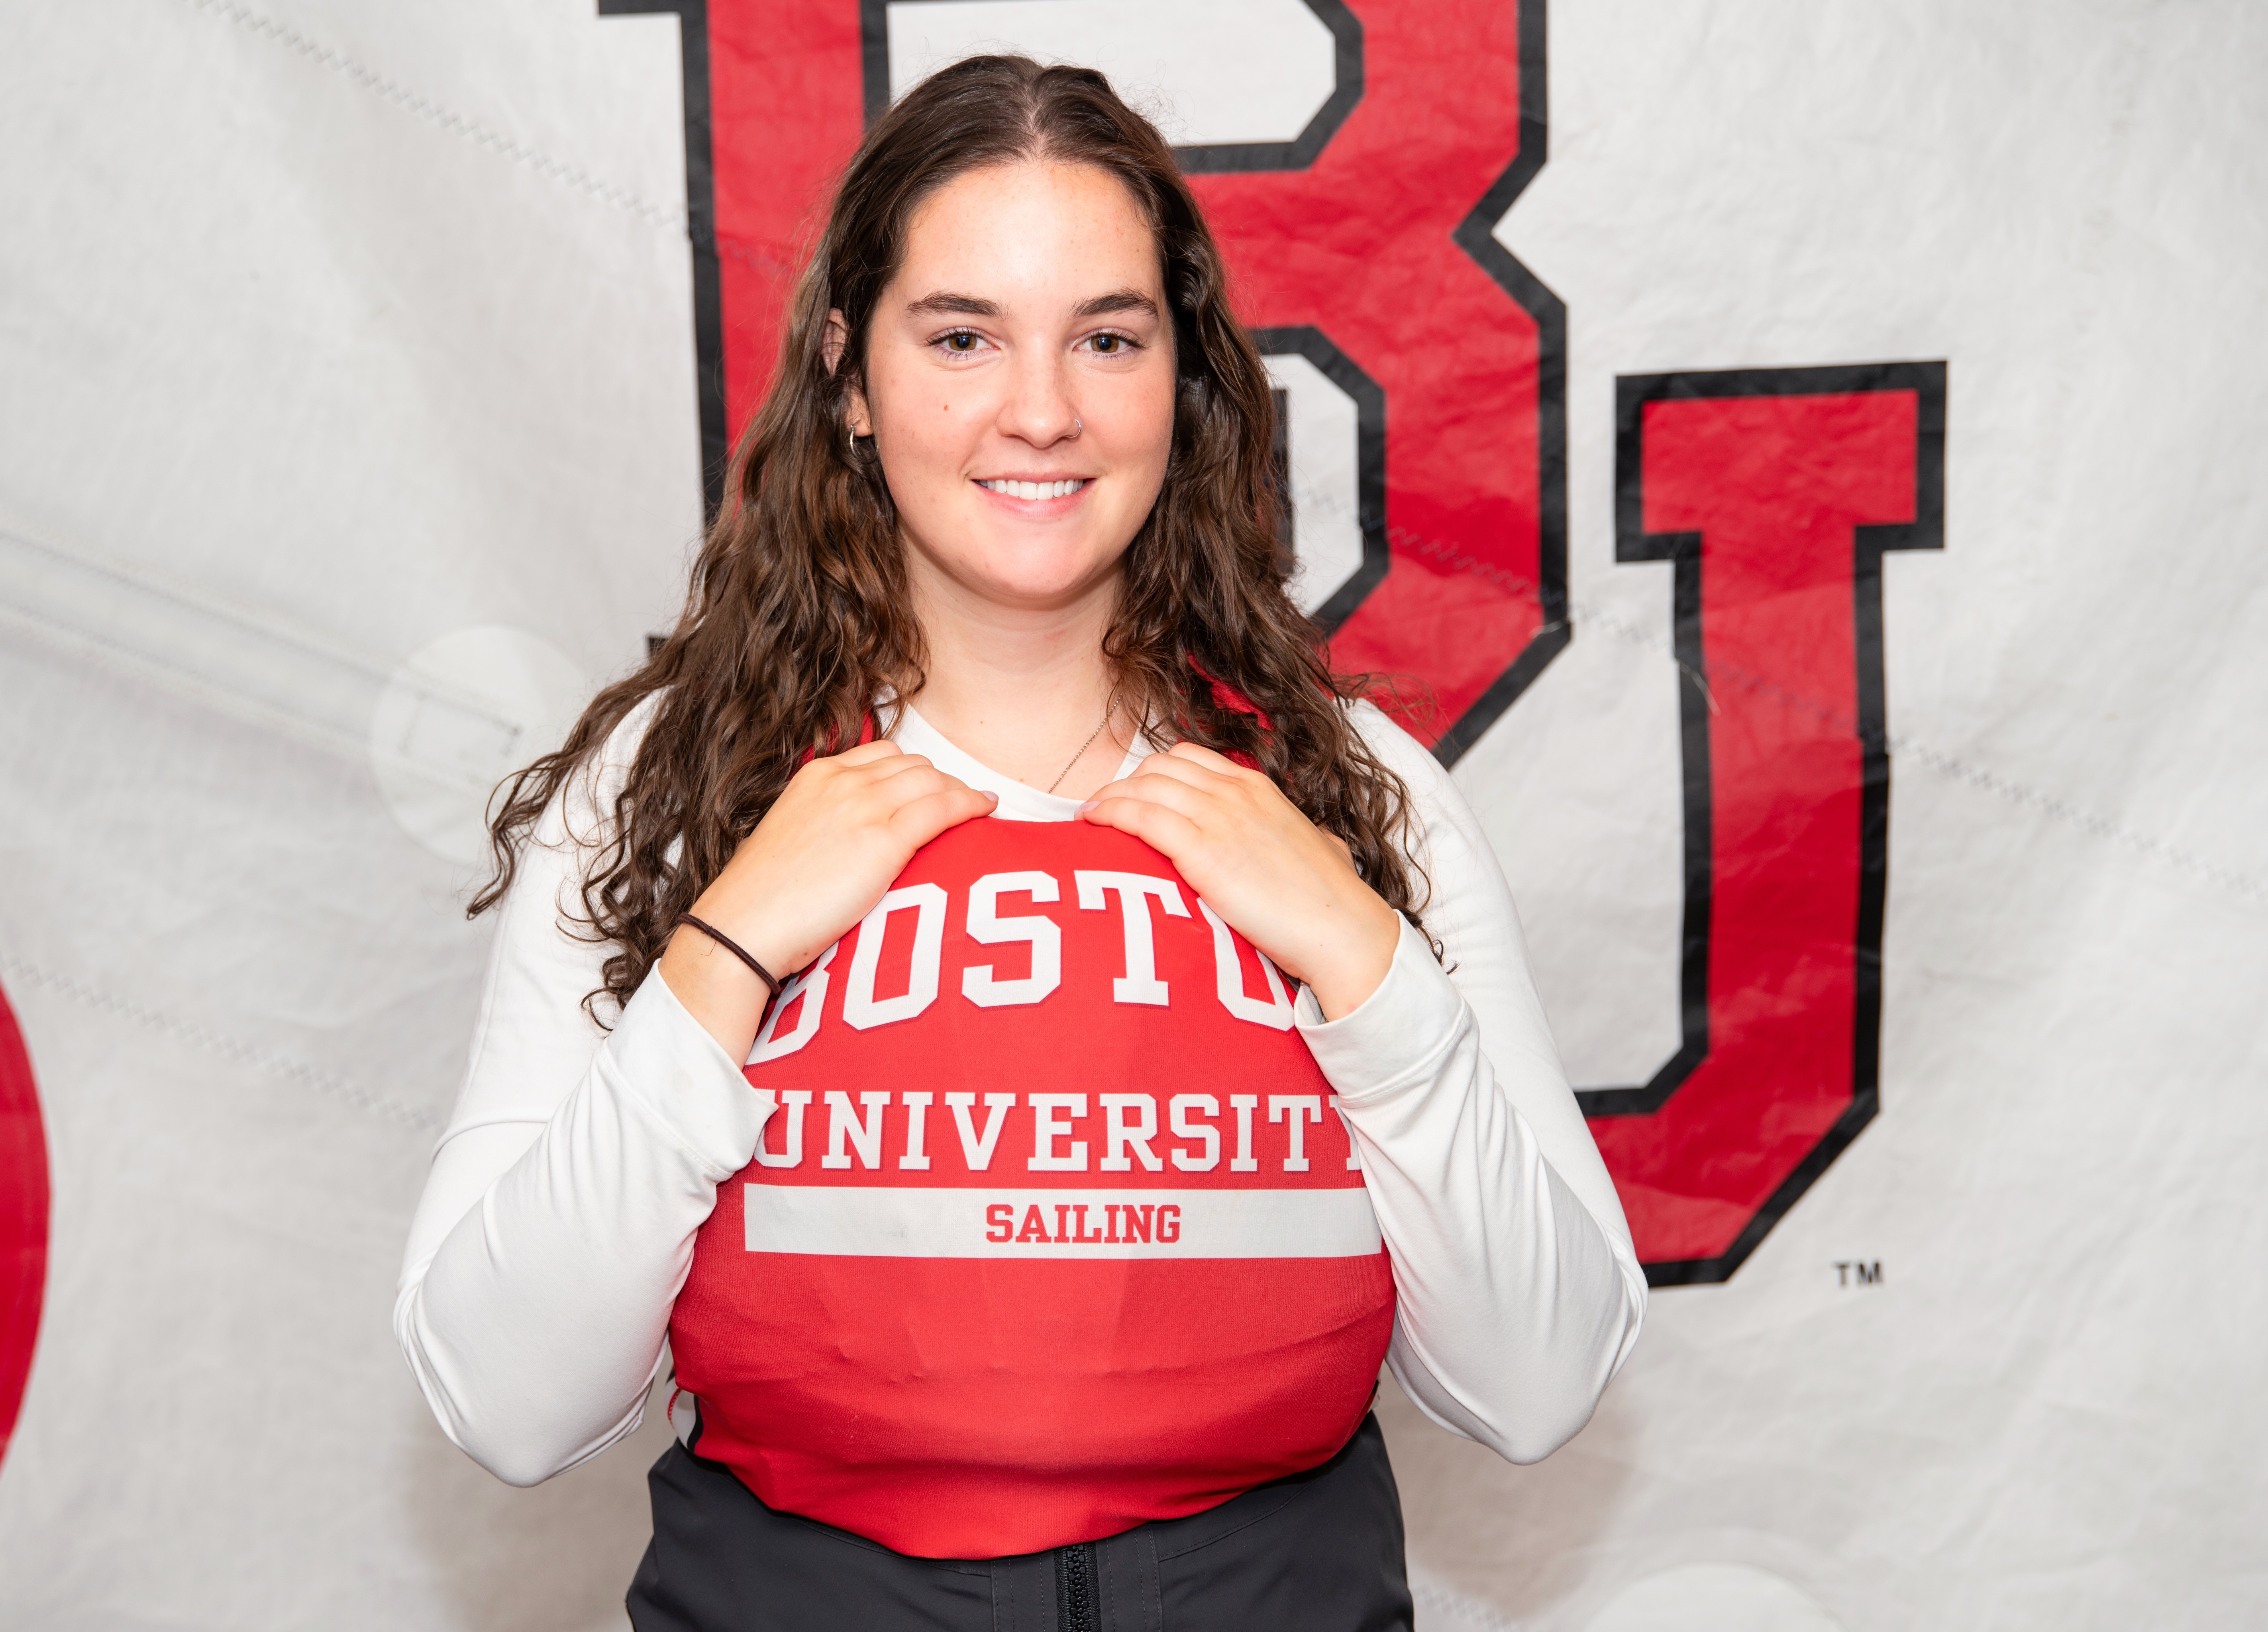

In [7]:
from IPython.display import Image
print('This is my query image')
Image(filename="Headshot2.jpeg")

In [9]:
from PIL import Image
from open_clip import create_model_and_transforms, tokenizer
import torch.nn.functional as F

model, _, preprocess = create_model_and_transforms('ViT-B/32', pretrained='openai')

# This converts the image to a tensor
image = preprocess(Image.open("Headshot2.jpeg")).unsqueeze(0)

# This calculates the query embedding
query_embedding = F.normalize(model.encode_image(image))

/Users/gracemurphy/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/open_clip/factory.py:372: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [14]:
# Retrieve the image path that corresponds to the embedding in `df`
# with the highest cosine similarity to query_embedding
embeddings = np.stack(df['embedding'].values)
if isinstance(query_embedding, torch.Tensor):
        query_embedding = query_embedding.detach().numpy()
similarities = cosine_similarity(embeddings, query_embedding.reshape(1, -1))
max_index = np.argmax(similarities)# Find the index of the highest similarity
impath = df.iloc[max_index]['file_name'] # Retrieve the corresponding image path
print(impath)

impath = '/Users/gracemurphy/Desktop/CS506/Assignments/Assignment 10/coco_images_resized/' + impath
print(impath)

COCO_train2014_000000243782.jpg
/Users/gracemurphy/Desktop/CS506/Assignments/Assignment 10/coco_images_resized/COCO_train2014_000000243782.jpg


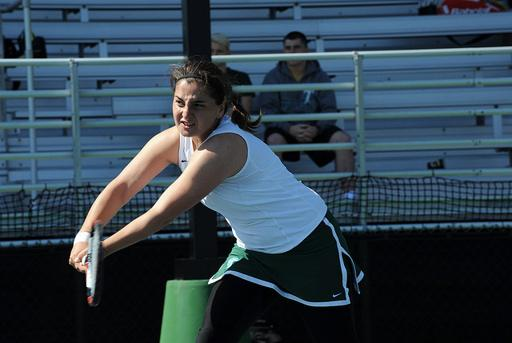

In [15]:
from IPython.display import Image
Image(filename=impath)

### Step 3: Text-to-Image Search

Now implement text-to-image-search.

The only difference here is that the query is a string of text. You will use the text encoder to obtain the corresponding query embedding.

COCO_train2014_000000022627.jpg
/Users/gracemurphy/Desktop/CS506/Assignments/Assignment 10/coco_images_resized/COCO_train2014_000000022627.jpg


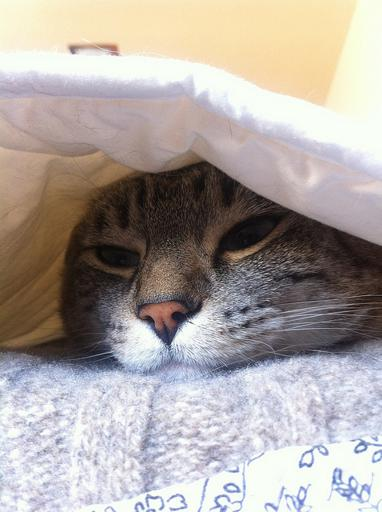

In [19]:
import open_clip
import torch
import torch.nn.functional as F
import pandas as pd
from IPython.display import Image

# Load the tokenizer and model
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.eval()

# Text input for querying the image
text = tokenizer(["cat."])
query_embedding = F.normalize(model.encode_text(text))

# Assuming df contains two columns: 'image_path' and 'embedding'
df = pd.read_pickle('image_embeddings.pickle')

# Convert the numpy embeddings to torch tensors and stack them
image_embeddings = torch.stack([torch.tensor(embedding) for embedding in df['embedding'].values])

# Ensure query_embedding is on the same device (CPU or GPU)
device = image_embeddings.device  # use the device of image_embeddings
query_embedding = query_embedding.to(device)

# Compute cosine similarity between the query embedding and each image embedding
cosine_similarities = F.cosine_similarity(query_embedding, image_embeddings)

# Get the index of the highest similarity
best_index = torch.argmax(cosine_similarities).item()

# Retrieve the image path corresponding to the highest similarity
impath = df.iloc[best_index]['file_name']
print(impath)

impath = '/Users/gracemurphy/Desktop/CS506/Assignments/Assignment 10/coco_images_resized/' + impath
print(impath)

from IPython.display import Image
Image(filename=impath)

### Step 4:  Hybrid Query

A more interesting query could contain both image and text.

For example, instead of explicitly searching for an "image of snowy house", you could search for "snowy" + an image of a house.


In this case, you should embed both the text query and the image query. Then, the query embedding is a weighted average of the two embeddings.

COCO_train2014_000000298164.jpg
/Users/gracemurphy/Desktop/CS506/Assignments/Assignment 10/coco_images_resized/COCO_train2014_000000298164.jpg


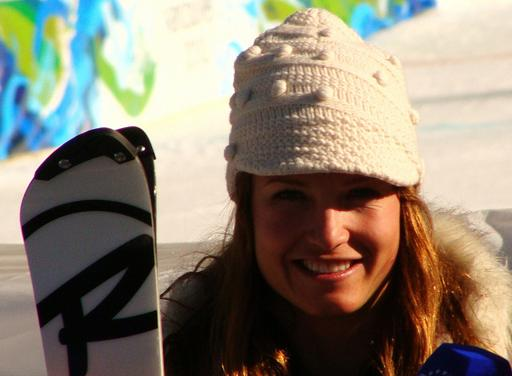

In [22]:
import open_clip
import torch
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from IPython.display import Image as IPImage

# Load the tokenizer and model
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B/32', pretrained='openai')
model.eval()

# Image query
image = preprocess(Image.open("Headshot2.jpeg")).unsqueeze(0)
image_query = F.normalize(model.encode_image(image))

# Text query
text = tokenizer(["snowy"])
text_query = F.normalize(model.encode_text(text))

# Weighted average for the combined query embedding
lam = 0.8  # Tune this to control the weight of the text and image embeddings
query = F.normalize(lam * text_query + (1.0 - lam) * image_query)

# Load the embeddings from the dataframe (assuming it has 'image_path' and 'embedding' columns)
df = pd.read_pickle('image_embeddings.pickle')

# Convert the numpy embeddings to torch tensors and stack them
image_embeddings = torch.stack([torch.tensor(embedding) for embedding in df['embedding'].values])

# Ensure query embedding is on the same device (CPU or GPU)
device = image_embeddings.device  # Use the device of image_embeddings
query = query.to(device)

# Compute cosine similarity between the query embedding and each image embedding
cosine_similarities = F.cosine_similarity(query, image_embeddings)

# Get the index of the highest similarity
best_index = torch.argmax(cosine_similarities).item()

# Retrieve the image path corresponding to the highest similarity
impath = df.iloc[best_index]['file_name']
print(impath)

impath = '/Users/gracemurphy/Desktop/CS506/Assignments/Assignment 10/coco_images_resized/' + impath
print(impath)

from IPython.display import Image
Image(filename=impath)